# Cassava Leaf Disease Classification
## Identify the type of disease present on a Cassava Leaf image
<br>
As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.



# Data

Can you identify a problem with a cassava plant using a photo from a relatively inexpensive camera? This competition will challenge you to distinguish between several diseases that cause material harm to the food supply of many African countries. In some cases the main remedy is to burn the infected plants to prevent further spread, which can make a rapid automated turnaround quite useful to the farmers.

**Files**
**[train/test]_images** the image files. The full set of test images will only be available to your notebook when it is submitted for scoring. Expect to see roughly 15,000 images in the test set.

**train.csv**

- image_id the image file name.

- label the ID code for the disease.

**sample_submission.csv** A properly formatted sample submission, given the disclosed test set content.

- image_id the image file name.

- label the predicted ID code for the disease.

**[train/test]_tfrecords** the image files in tfrecord format.

**label_num_to_disease_map.json** The mapping between each disease code and the real disease name.

In [1]:
import os
import albumentations
import  matplotlib.pyplot as plt
import pandas as pd

import tez

from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn

import torchvision

from sklearn import metrics, model_selection
from efficientnet_pytorch import EfficientNet


%matplotlib inline


In [2]:
dfx = pd.read_csv("train.csv")

In [3]:
dfx.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
dfx.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [5]:
df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.1, random_state=42, stratify=dfx.label.values
)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

# Sampling only 10% for prototype

df_train, df_valid = model_selection.train_test_split(
    df_valid, test_size=0.1, random_state=42, stratify=df_valid.label.values
)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)



print(df_train.shape)
print(df_valid.shape)

(1926, 2)
(214, 2)


In [6]:
image_path = './train_images'

train_image_paths = [
    os.path.join(image_path, x) for x in df_train.image_id.values
]

valid_image_paths = [
    os.path.join(image_path, x) for x in df_valid.image_id.values
]

train_image_paths[:5]

['./train_images\\2632382068.jpg',
 './train_images\\2467650038.jpg',
 './train_images\\2391557874.jpg',
 './train_images\\476487552.jpg',
 './train_images\\1035014017.jpg']

In [7]:
train_targets = df_train.label.values
valid_targets = df_valid.label.values

In [8]:
# augmentations taken from: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug
train_aug = albumentations.Compose([
            albumentations.RandomResizedCrop(256, 256),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5)
#             albumentations.ShiftScaleRotate(p=0.5),
#             albumentations.HueSaturationValue(
#                 hue_shift_limit=0.2, 
#                 sat_shift_limit=0.2, 
#                 val_shift_limit=0.2, 
#                 p=0.5
#             ),
#             albumentations.RandomBrightnessContrast(
#                 brightness_limit=(-0.1,0.1), 
#                 contrast_limit=(-0.1, 0.1), 
#                 p=0.5
#             ),
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
#             albumentations.CoarseDropout(p=0.5),
#             albumentations.Cutout(p=0.5)


], p=1.)
  
        
valid_aug = albumentations.Compose([
            albumentations.CenterCrop(256, 256, p=1.),
            albumentations.Resize(256, 256),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5)
#             albumentations.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             )

], p=1.)

In [9]:
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    augmentations=train_aug
)

valid_dataset = ImageDataset(
    image_paths=valid_image_paths,
    targets=valid_targets,
    augmentations=valid_aug
)

# train_dataset = ImageDataset(
#     image_paths=train_image_paths,
#     targets=train_targets,
#     augmentations=None
# )

# valid_dataset = ImageDataset(
#     image_paths=valid_image_paths,
#     targets=valid_targets,
#     augmentations=None
# )

In [10]:
def plot_img(image_dict):
    img_tensor = image_dict["image"]
    target = image_dict["targets"]
    print(target)
    plt.figure(figsize=(10, 10))
    image = img_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

In [11]:
# train_dataset[10]

tensor(1)


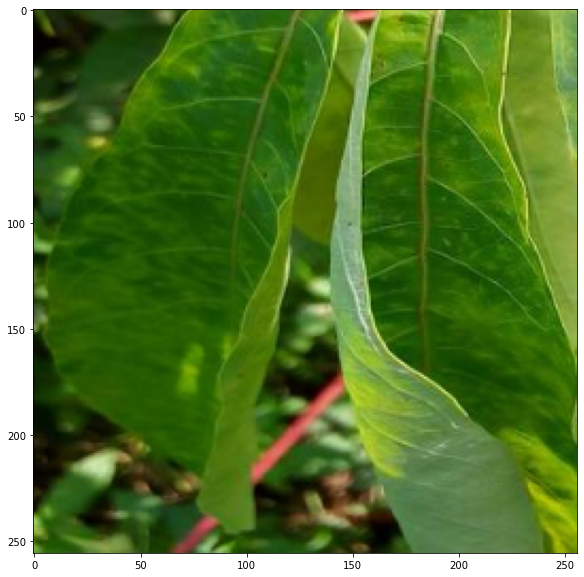

In [12]:
plot_img(train_dataset[0])

In [13]:
# class LeafModel(tez.Model):
#     def __init__(self, num_classes):
#         super().__init__()

#         self.effnet = EfficientNet.from_pretrained("efficientnet-b0")
#         self.dropout = nn.Dropout(0.1)
#         self.out = nn.Linear(1792, num_classes)
#         self.step_scheduler_after = "epoch"

#     def forward(self, image, targets=None):
#         batch_size, _, _, _ = image.shape

#         x = self.effnet.extract_features(image)
#         x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
#         outputs = self.out(self.dropout(x))
#         return outputs, None, None

In [14]:
class LeafModel(tez.Model):
    def __init__(self, num_classes, pretrained):
        super().__init__()

        self.convnet = torchvision.models.resnet18(pretrained=pretrained)
        self.convnet.fc = nn.Linear(512, num_classes)
        self.step_scheduler_after = "epoch"
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.CrossEntropyLoss()(outputs, targets)
    
    def monitor_metrics(self, outputs, targets):
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        acc = metrics.accuracy_score(targets, outputs)
        return  {
            "accuracy": acc
        }
    
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt
    
    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=0.7)
        return sch

    def forward(self, image, targets=None):
        outputs = self.convnet(image)
        if targets is not None:
            loss = self.loss(outputs, targets)
            mon_metrics = self.monitor_metrics(outputs, targets)
            return outputs, loss, mon_metrics
        else:
            return outputs, None, None

In [15]:
model = LeafModel(num_classes=dfx.label.nunique(), pretrained=True)

In [16]:
img = train_dataset[0]["image"]
y = train_dataset[0]["targets"]
model(img.unsqueeze(0), y.unsqueeze(0))

(tensor([[-0.1507,  1.0422,  0.1342, -1.1264,  0.5168]],
        grad_fn=<AddmmBackward>),
 tensor(0.8806, grad_fn=<NllLossBackward>),
 {'accuracy': 1.0})

In [ ]:
es = EarlyStopping(monitor="valid_accuracy", model_path="model.bin", patience=2, mode="max")
model.fit(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    train_bs = 32,
    valid_bs = 32,
    callbacks=[es],
    fp16=True,
    epochs=10,
    device="cuda"
    
)

100%|█████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s, accuracy=0.569, loss=2.28, stage=valid]


Validation score improved (-inf --> 0.5693993506493507). Saving model!


100%|██████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.76it/s, accuracy=0.64, loss=1.32, stage=valid]


Validation score improved (0.5693993506493507 --> 0.6400162337662338). Saving model!


 38%|██████████████████▊                               | 23/61 [00:31<00:52,  1.38s/it, accuracy=0.648, loss=0.962, stage=train]